In [2]:
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 3

import xarray as xr
import matplotlib.pyplot as plt
from helpers.computational_tools import *
import xesmf as xe
import xgcm

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from helpers.collection_of_experiments import CollectionOfExperiments

In [87]:
from xgcm import Grid
import numpy as np
import xarray as xr
from xgcm.grid_ufunc import as_grid_ufunc

# Here we create arrays for V_{i+1,j} and V_{i,j+1}
@as_grid_ufunc(signature="(X:center)->(X:outer)", boundary_width={'X':(1,1)})
def index_plus_one(a):
    return a[...,1:]

# Central value also should be given on a grid of outer values.
@as_grid_ufunc(signature="(X:center)->(X:outer)", boundary_width={'X':(1,0)})
def index_center(a):
    return a[...,:]
    
class GMFilter():
  '''
  Filter which uses Gent-McWilliams parameterization
  to perform filtering of layer interfaces
  '''
  def __init__(self, static, lower_interface):
    '''
    Required fields in static:
    wet_u, wet_v
    wet
    '''
    self.static = static.fillna(0.)
    self.lower_interface = lower_interface.fillna(0.)

    self.grid = Grid(self.static, coords={
            'X': {'center': 'xh', 'outer': 'xq'},
            'Y': {'center': 'yh', 'outer': 'yq'}
            },
            boundary={'X': 'periodic', 'Y': 'fill'},
            fill_value = {'Y': 0})

  def limit_fluxes(self, eta, Fu, Fv):
    '''
    This function assumes that perform
    one time step with layer interfaces as follows:
    eta_new = eta + (diff(Fu,'X') + diff(Fv,'Y')) / area_t

    And we want to be sure that after time step interfaces do
    not drop below the bathymetry, that is:
    eta_new >= bathymetry for all layers
    as long as interfaces were above bathymetry before diffusion
    if  eta >= bathymetry for all layers

    We introduce the volume enclosed into the water column
    below the interface:
    V = (eta-bathymetry) * area_t
    Then the limited fluxes should satisfy:
    diff(Fu,'X') + diff(Fv,'Y') + V >= 0.

    We assume that 4 fluxes on edges can work IN CONCERT (see Zalesak 1979 for definition),
    but we want to limit them independently
    Thus, we require (see divisor 4):
    Fu_{i+1/2}>0 -> -Fu_{i+1/2} + V_{i+1}/4 >=0
    Fu_{i+1/2}<0 -> +Fu_{i+1/2} + V_{i}/4   >=0

    Fv_{j+1/2}>0 -> -Fv_{j+1/2} + V_{j+1}/4 >=0
    Fu_{j+1/2}<0 -> +Fv_{j+1/2} + V_{j}/4   >=0
    '''

    static = self.static
    grid = self.grid

    # Compute volume below interface
    V = (eta - self.lower_interface) * static.wet

    # See explanation of dask="parallelized" in
    # https://xgcm.readthedocs.io/en/latest/grid_ufuncs.html
    V_right = index_plus_one(grid, V, axis='X', dask="parallelized")
    V_top   = index_plus_one(grid, V, axis='Y', dask="parallelized")

    Vu_center = index_center(grid, V, axis='X', dask="parallelized")
    Vv_center = index_center(grid, V, axis='Y', dask="parallelized")

    Fu = xr.where(Fu>0, np.minimum(Fu, V_right * 0.25), np.maximum(Fu, -Vu_center * 0.25))
    Fv = xr.where(Fv>0, np.minimum(Fv, V_top   * 0.25), np.maximum(Fv, -Vv_center * 0.25))

    return Fu, Fv

  def diffusion_fixed_factor(self, eta, filter_scale=4, limit_fluxes=True):
    '''
    This function computes diffusivity fluxes (Fu,Fv)
    in finite volume formulation and performs time stepping as
    follows:
    eta = eta + (diff(Fu * kappa_u,'X') + diff(Fv * kappa_v,'Y')) / area_t

    where kappa_u and kappa_v have physical meaning of:
    kappa = diffusivity coefficient x time spacing

    and chosen as much as possible (while stable)
    '''

    static = self.static
    grid = self.grid

    # Niters * kappa_max = filter_scale**2 / 24
    # Here we assume that kappa_max=0.25 on uniform grid
    kappa_max=0.25
    Niters = filter_scale**2 / 24. / kappa_max
    Niters = int(np.ceil(Niters + 0.01)) # we add 0.01 to make sure that resulting kappa is less than 0.25 in all cases

    kappa = filter_scale**2 / 24. / Niters

    etaf = eta.fillna(0.).copy(deep=True)

    print('Number of iterations of filter:', Niters)
    print('Kappa', kappa, 'must be strictly less than 0.25')

    for iter in range(Niters):
      # Fu_{i+1/2} = eta_i+1 - eta_i
      Fu = grid.diff(etaf,'X') * static.wet_u
      Fv = grid.diff(etaf,'Y') * static.wet_v

      # Multiply by diffusivity
      Fu = Fu * kappa
      Fv = Fv * kappa
      if limit_fluxes:
        Fu, Fv = self.limit_fluxes(etaf, Fu, Fv)
      # If kappa was 0.25, it will be
      # eta_{ij} = 0.25 * (eta_i+1 + eta_i-1 + eta_j+1 + eta_j-1)
      etaf = (etaf + grid.diff(Fu, 'X') + grid.diff(Fv, 'Y')) * static.wet

    return xr.where(np.isnan(eta),np.nan,etaf)

In [6]:
ref = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/snapshots_*', decode_times=False, chunks={'time':1}).e.isel(time=0).load().chunk({'zi':1})
ref_static = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/static.nc', decode_times=False).squeeze().drop_vars('time')

In [16]:
from dask.diagnostics import ProgressBar

In [112]:
lower_interface = ref.isel(zi=-1).squeeze().drop_vars(['time','zi'])
gmfilter = GMFilter(ref_static, lower_interface)

etaf_FGR = gmfilter.diffusion_fixed_factor(ref.isel(zi=-3),filter_scale=24,limit_fluxes=True)
etaf_bottom = gmfilter.diffusion_fixed_factor(ref.isel(zi=-1),filter_scale=24,limit_fluxes=True)
with ProgressBar():
    etaf_FGR = etaf_FGR.compute()
    etaf_bottom = etaf_bottom.compute()

Number of iterations of filter: 97
Kappa 0.24742268041237114 must be strictly less than 0.25
Number of iterations of filter: 97
Kappa 0.24742268041237114 must be strictly less than 0.25
[########################################] | 100% Completed | 61.76 ss
[########################################] | 100% Completed | 62.64 s


In [25]:
filter_h = gcm_filters.Filter(
                filter_scale=24, # filter scale accounts for change in resolution (32/4) and FGR (3)
                dx_min=1,
                filter_shape=gcm_filters.FilterShape.GAUSSIAN,
                grid_type=gcm_filters.GridType.REGULAR_WITH_LAND,
                grid_vars={'wet_mask': ref_static.wet}
                )
print(filter_h.n_steps)
with ProgressBar():
    etaf_baseline = filter_h.apply(ref.isel(zi=-3), dims=['yh','xh']).compute()

27
[########################################] | 100% Completed | 11.55 ss


In [111]:
# etaf_baseline.to_netcdf('etaf_GCMfilter.nc')
#etaf_FGR.to_netcdf('etaf_GMfilter.nc')
#etaf_baseline = xr.open_dataset('etaf_GCMfilter.nc').__xarray_dataarray_variable__
etaf_FGR = xr.open_dataset('etaf_GMfilter.nc').__xarray_dataarray_variable__

(0.0, 60.0, -70.0, 70.0)

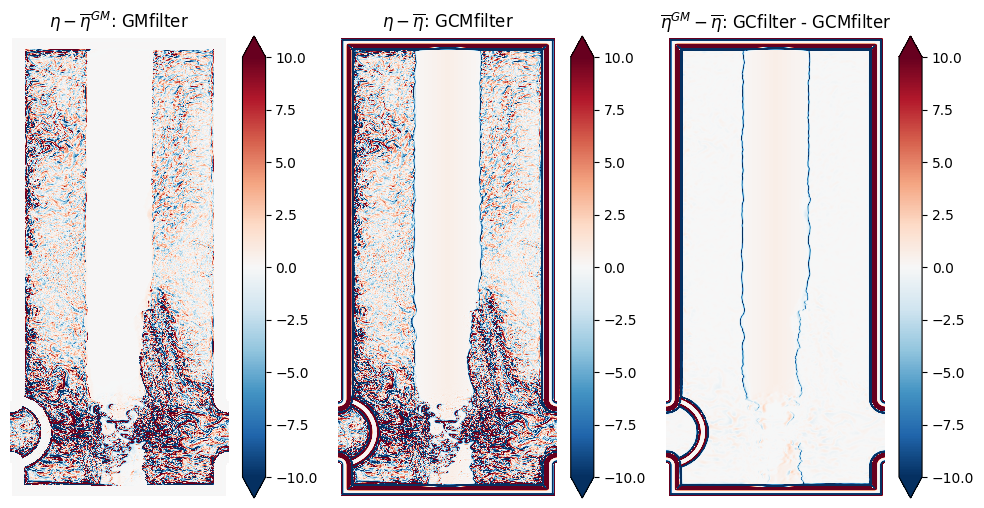

In [103]:
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
(ref.isel(zi=-3)-etaf_FGR).plot(vmin=-10)
plt.title('$\\eta-\overline{\\eta}^{GM}$: GMfilter')
plt.gca().axis('off')
plt.subplot(1,3,2)
(ref.isel(zi=-3)-etaf_baseline).plot(vmin=-10)
plt.title('$\\eta-\overline{\\eta}$: GCMfilter')
plt.gca().axis('off')
plt.subplot(1,3,3)
(etaf_FGR - etaf_baseline).plot(vmin=-10)
plt.title('$\overline{\\eta}^{GM} - \overline{\\eta}$: GCfilter - GCMfilter')
plt.gca().axis('off')

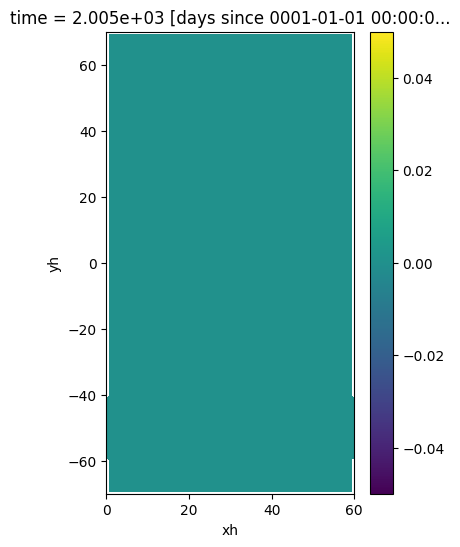

In [114]:
# For bottom layer the fluxes are all zero and array are the same!
plt.figure(figsize=(4,6))
(ref.isel(zi=-1)-etaf_bottom).plot(robust=True)

(0.0, 60.0, -70.0, 70.0)

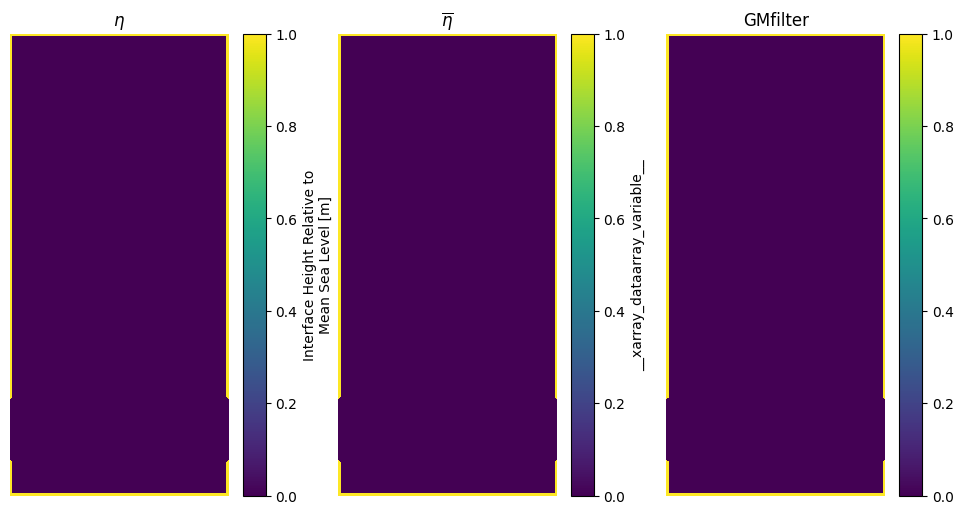

In [104]:
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
np.isnan(ref.isel(zi=-3)).plot()
plt.title('$\\eta$')
plt.gca().axis('off')
plt.subplot(1,3,2)
np.isnan(etaf_baseline).plot()
plt.title('$\overline{\\eta}$')
plt.gca().axis('off')
plt.subplot(1,3,3)
np.isnan(etaf_FGR).plot()
plt.title('GMfilter')
plt.gca().axis('off')

In [105]:
np.array_equal(np.isnan(ref.isel(zi=-3)), np.isnan(etaf_FGR))

True

In [106]:
import xrft

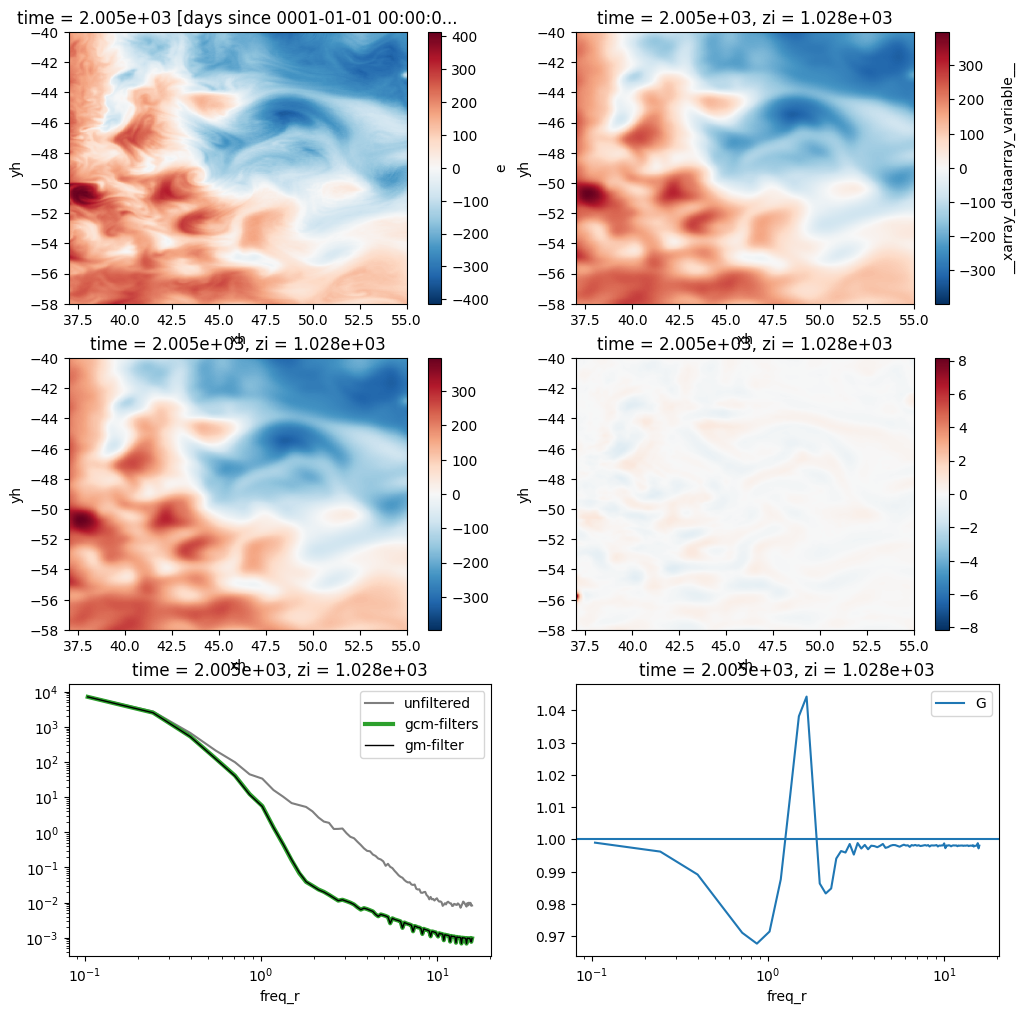

In [109]:
plt.figure(figsize=(12,12))
x = ref.isel(zi=-3).sel(xh=slice(37,55), yh=slice(-58,-40))
y = etaf_baseline.sel(xh=slice(37,55), yh=slice(-58,-40))
z = etaf_FGR.sel(xh=slice(37,55), yh=slice(-58,-40))
x = x - x.mean()
y = y - y.mean()
z = z - z.mean()

plt.subplot(3,2,1)
x.plot()
plt.subplot(3,2,2)
y.plot()
plt.subplot(3,2,3)
z.plot()
plt.subplot(3,2,4)
(y-z).plot()
plt.subplot(3,2,5)
xrft_kw = dict(detrend='linear', window='hamming', window_correction=True, truncate=True)
xf = xrft.isotropic_power_spectrum(x, dims=['yh','xh'],**xrft_kw)
yf = xrft.isotropic_power_spectrum(y, dims=['yh','xh'],**xrft_kw)
zf = xrft.isotropic_power_spectrum(z, dims=['yh','xh'],**xrft_kw)
xf.plot(xscale='log',yscale='log', color='tab:gray', label='unfiltered')
yf.plot(xscale='log',yscale='log', label='gcm-filters', lw=3, color='tab:green')
zf.plot(xscale='log',yscale='log', label='gm-filter', ls='-', lw=1, color='k')
plt.legend()
plt.subplot(3,2,6)
(zf/yf).plot(xscale='log')
plt.legend('GM/GCM spectrum')
plt.axhline(y=1)

In [116]:
%%time
# Check runtime
lower_interface = ref.isel(zi=-1).squeeze().drop_vars(['time','zi'])
gmfilter = GMFilter(ref_static, lower_interface)

etaf_FGR = gmfilter.diffusion_fixed_factor(ref,filter_scale=24,limit_fluxes=True)
with ProgressBar():
    etaf_FGR = etaf_FGR.compute()

Number of iterations of filter: 97
Kappa 0.24742268041237114 must be strictly less than 0.25
[########################################] | 100% Completed | 397.40 s
CPU times: user 21min 37s, sys: 12min 53s, total: 34min 30s
Wall time: 7min 15s


In [4]:
test = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/filter_scale_0.75/interfaces/time_*.nc', 
                         concat_dim='time', combine='nested').sortby('time')

In [6]:
test.ef.time

<xarray.DataArray 'time' (time: 160)> Size: 1kB
array([2005., 2010., 2015., 2020., 2025., 2030., 2035., 2040., 2045., 2050.,
       2055., 2060., 2065., 2070., 2075., 2080., 2085., 2090., 2095., 2100.,
       2105., 2110., 2115., 2120., 2125., 2130., 2135., 2140., 2145., 2150.,
       2155., 2160., 2165., 2170., 2175., 2180., 2185., 2190., 2195., 2200.,
       2205., 2210., 2215., 2220., 2225., 2230., 2235., 2240., 2245., 2250.,
       2255., 2260., 2265., 2270., 2275., 2280., 2285., 2290., 2295., 2300.,
       2305., 2310., 2315., 2320., 2325., 2330., 2335., 2340., 2345., 2350.,
       2355., 2360., 2365., 2370., 2375., 2380., 2385., 2390., 2395., 2400.,
       2405., 2410., 2415., 2420., 2425., 2430., 2435., 2440., 2445., 2450.,
       2455., 2460., 2465., 2470., 2475., 2480., 2485., 2490., 2495., 2500.,
       2505., 2510., 2515., 2520., 2525., 2530., 2535., 2540., 2545., 2550.,
       2555., 2560., 2565., 2570., 2575., 2580., 2585., 2590., 2595., 2600.,
       2605., 2610., 2615., 2620., 2625., 2630., 2635., 2640., 2645., 2650.,
       2655., 2660., 2665., 2670., 2675., 2680., 2685., 2690., 2695., 2700.,
       2705., 2710., 2715., 2720., 2725., 2730., 2735., 2740., 2745., 2750.,
       2755., 2760., 2765., 2770., 2775., 2780., 2785., 2790., 2795., 2800.])
Coordinates:
  * time     (time) float64 1kB 2.005e+03 2.01e+03 ... 2.795e+03 2.8e+03

In [7]:
test.hf.min().values

array(-9.094947e-13, dtype=float32)

In [8]:
(test.ef - test.ef.isel(time=0,zi=-1).drop_vars(['time','zi'])).min().values

array(0., dtype=float32)

In [9]:
test['hf'] = np.maximum(test['hf'], 0.0)

In [13]:
test.to_netcdf('/scratch/pp2681/mom6/Neverworld2/simulations/R32/filter_scale_0.75/interfaces-GMfilter.nc')

In [14]:
new = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/filter_scale_0.75/interfaces-GMfilter.nc')

In [16]:
old =xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/filter_scale_0.75/merged_dataset.nc')

(0.0, 60.0, -70.0, 70.0)

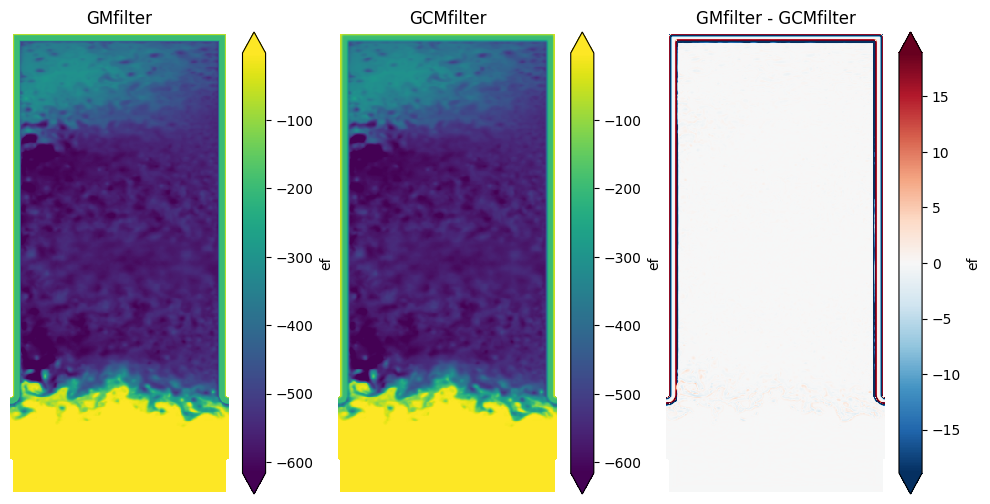

In [31]:
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
(new).ef.isel(time=100,zi=5).plot(robust=True)
plt.title('GMfilter')
plt.gca().axis('off')
plt.subplot(1,3,2)
(old).ef.isel(time=100,zi=5).plot(robust=True)
plt.title('GCMfilter')
plt.gca().axis('off')
plt.subplot(1,3,3)
(new-old).ef.isel(time=100,zi=5).plot(robust=True)
plt.title('GMfilter - GCMfilter')
plt.gca().axis('off')

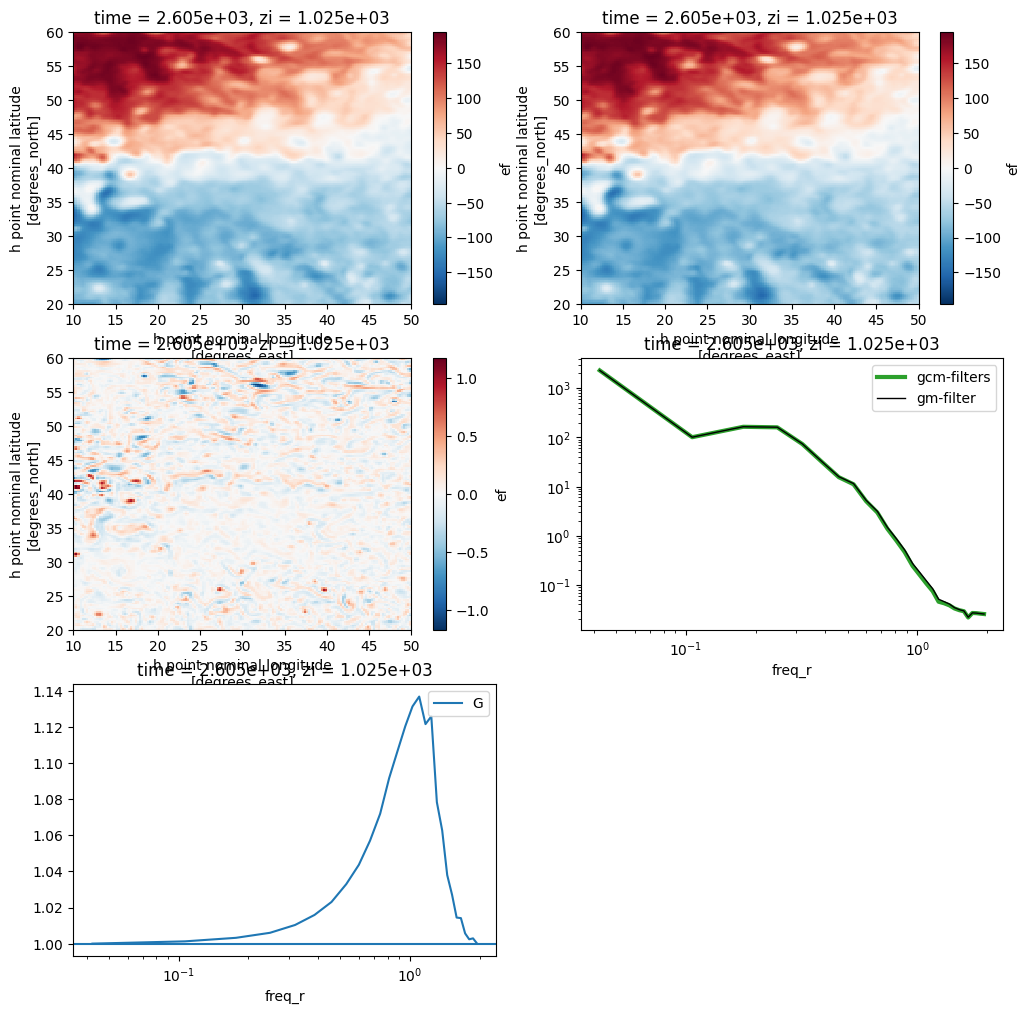

In [33]:
plt.figure(figsize=(12,12))
x = new.ef.isel(zi=5, time=120).sel(xh=slice(10,50), yh=slice(20,60))
y = old.ef.isel(zi=5, time=120).sel(xh=slice(10,50), yh=slice(20,60))
x = x - x.mean()
y = y - y.mean()

plt.subplot(3,2,1)
x.plot()
plt.subplot(3,2,2)
y.plot()
plt.subplot(3,2,3)
(x-y).plot()
plt.subplot(3,2,4)
xrft_kw = dict(detrend='linear', window='hamming', window_correction=True, truncate=True)
xf = xrft.isotropic_power_spectrum(x, dims=['yh','xh'],**xrft_kw)
yf = xrft.isotropic_power_spectrum(y, dims=['yh','xh'],**xrft_kw)
yf.plot(xscale='log',yscale='log', label='gcm-filters', lw=3, color='tab:green')
xf.plot(xscale='log',yscale='log', label='gm-filter', ls='-', lw=1, color='k')
plt.legend()
plt.subplot(3,2,5)
(xf/yf).plot(xscale='log')
plt.legend('GM/GCM spectrum')
plt.axhline(y=1)

# Check APE

In [34]:
def APE(interface):
    '''
    Returns APE in units of kinetic energy per unit mass, i.e.
    m^3/s^2
    '''
    interface_rest = xr.DataArray([    0.,   -25.,   -75.,  -175.,  -300.,  -450.,  -625.,  -825.,
       -1050., -1300., -1600., -1950., -2350., -2850., -3400., -4000.], dims='zi')
    g = xr.DataArray([1.0e+01, 2.1e-03, 3.9e-03, 5.4e-03, 5.8e-03, 5.8e-03, 5.7e-03,
       5.3e-03, 4.8e-03, 4.2e-03, 3.7e-03, 3.1e-03, 2.4e-03, 1.7e-03,
       1.1e-03, 0.0e+00], dims='zi')
    
    coordinate_of_bottom = interface.isel(zi=-1).drop_vars(['zi'])
    
    hint = interface - interface_rest
    
    # Where bottom is upper than the rest interface
    hbot = np.maximum(coordinate_of_bottom - interface_rest,0)
    
    APE_instant = (0.5 * g * (hint**2))
    APE_constant = (0.5 * g * (hbot**2))
    
    return (APE_instant - APE_constant).sum('zi')

In [40]:
R32 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/snapshots_*', decode_times=False, chunks={'time':1})

In [36]:
R4_FGR3_gcmfilters = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/filter_scale_0.75/merged_dataset.nc', decode_times=False)

In [37]:
R4_FGR3_gmfilter = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/filter_scale_0.75/interfaces-GMfilter.nc', decode_times=False)

In [71]:
R4_coarsen = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/coarsened_snapshots.nc', decode_times=False)

In [38]:
ref_static = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/static.nc', decode_times=False).squeeze().drop_vars('time')

In [39]:
lores_static = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/bare/output/static.nc', decode_times=False)

In [41]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    APE_R32 = (APE(R32.e) * ref_static.area_t).sum(['xh','yh']).compute()

[########################################] | 100% Completed | 194.45 s


In [43]:
with ProgressBar():
    APE_R4_gcmfilters = (APE(R4_FGR3_gcmfilters.ef) * lores_static.area_t).sum(['xh','yh']).compute()

[########################################] | 100% Completed | 11.58 ss


In [44]:
with ProgressBar():
    APE_R4_gmfilter = (APE(R4_FGR3_gmfilter.ef) * lores_static.area_t).sum(['xh','yh']).compute()

[########################################] | 100% Completed | 12.85 ss


In [72]:
with ProgressBar():
    APE_R4_coarsen = (APE(R4_coarsen.e) * lores_static.area_t).sum(['xh','yh']).compute()

[########################################] | 100% Completed | 3.62 ss


In [65]:
series = xr.open_dataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/ocean_stats.nc', decode_times=False).APE.sum('Interface')

Text(0, 0.5, 'APE [J]')

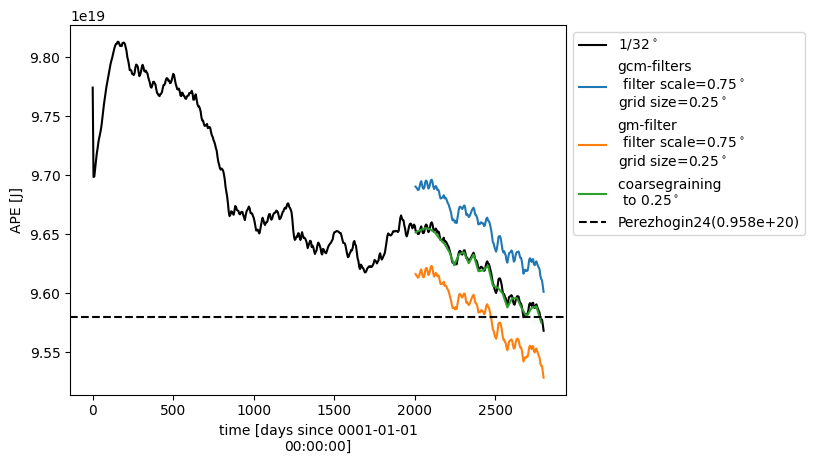

In [81]:
#(1000*APE_R32).plot(color='k', label='$1/32^\circ$', lw=3)
series.plot(color='k', label='$1/32^\circ$')
(1000*APE_R4_gcmfilters).plot(label='gcm-filters\n filter scale=$0.75^\circ$\ngrid size=$0.25^\circ$')
(1000*APE_R4_gmfilter).plot(label='gm-filter\n filter scale=$0.75^\circ$\ngrid size=$0.25^\circ$')
(1000*APE_R4_coarsen).plot(label='coarsegraining \n to $0.25^\circ$')
plt.axhline(y=0.958e+20, color='k', ls='--', label='Perezhogin24(0.958e+20)')
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('APE [J]')
#plt.ylim([0,1.2e+20])

In [82]:
import xrft

In [128]:
with ProgressBar():
    power_R32 = xrft.power_spectrum(R32.e.sel(time=slice(None,None,6)),dim='xh', nfactor=1).sel(yh=-50,method='nearest').isel(zi=10).mean('time').compute()

[########################################] | 100% Completed | 34.88 s


In [130]:
with ProgressBar():
    power_R4_gcm = xrft.power_spectrum(R4_FGR3_gcmfilters.ef.sel(time=slice(None,None,6)),dim='xh',nfactor=1).sel(yh=-50,method='nearest').isel(zi=10).mean('time').compute()
    power_R4_gm = xrft.power_spectrum(R4_FGR3_gmfilter.ef.sel(time=slice(None,None,6)),dim='xh',nfactor=1).sel(yh=-50,method='nearest').isel(zi=10).mean('time').compute()
    power_R4_coarsen = xrft.power_spectrum(R4_coarsen.e,dim='xh',nfactor=1).sel(yh=-50,method='nearest').isel(zi=10).mean('time').compute()

[########################################] | 100% Completed | 2.42 sms
[########################################] | 100% Completed | 2.31 sms
[########################################] | 100% Completed | 2.31 ss


In [135]:
((R32.e.sel(time=slice(None,None,6)).sel(yh=-50,method='nearest').isel(zi=10))).var().values

array(21142.39272953)

In [136]:
((R4_FGR3_gcmfilters.ef.sel(time=slice(None,None,6)).sel(yh=-50,method='nearest').isel(zi=10))).var().values

array(20205.818, dtype=float32)

In [137]:
((R4_FGR3_gmfilter.ef.sel(time=slice(None,None,6)).sel(yh=-50,method='nearest').isel(zi=10))).var().values

array(20252.293, dtype=float32)

In [140]:
((R4_coarsen.e.sel(yh=-50,method='nearest').isel(zi=10))).var().values

array(21055.1212002)

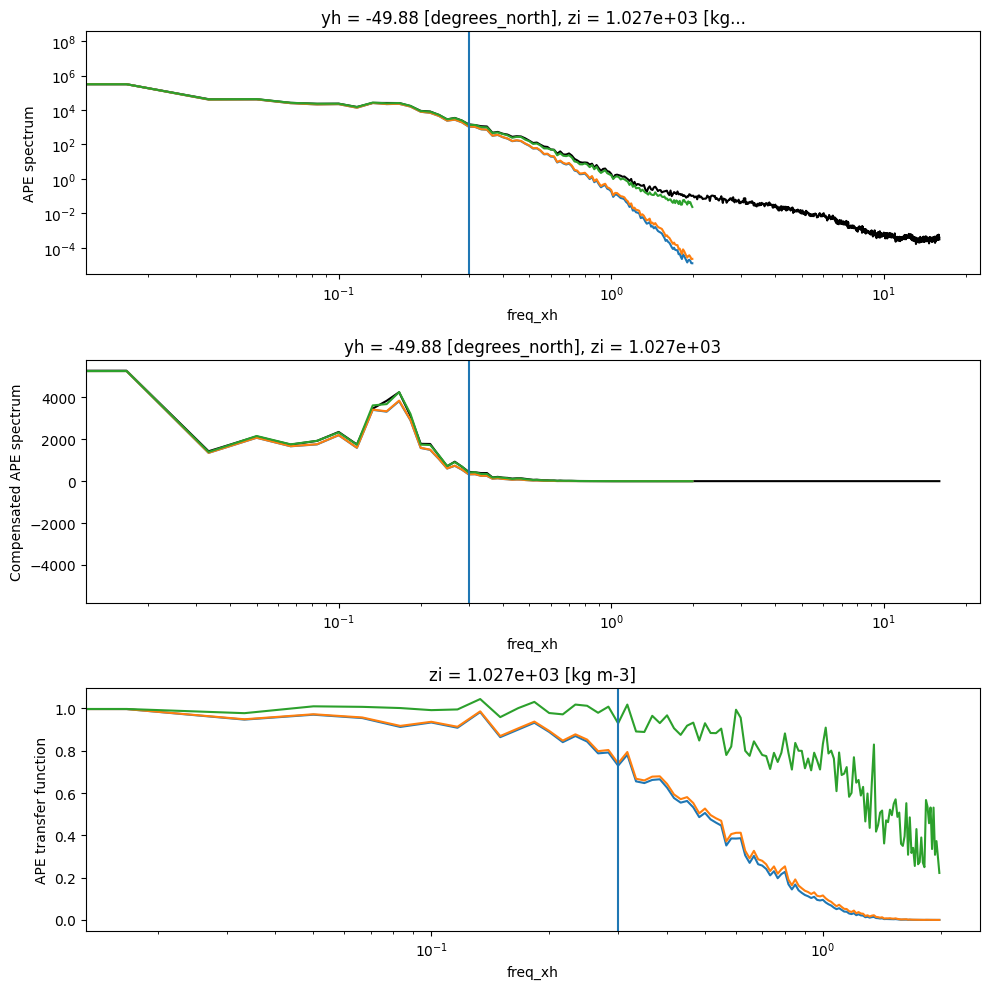

In [131]:
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
power_R32.plot(xscale='log',yscale='log', color='k')
power_R4_gcm.plot(color='tab:blue')
power_R4_gm.plot(color='tab:orange')
power_R4_coarsen.plot(color='tab:green')
plt.ylabel('APE spectrum')

plt.axvline(x=0.3)

plt.subplot(3,1,2)
(power_R32.freq_xh * power_R32).plot(xscale='log', color='k')
(power_R4_gcm.freq_xh * power_R4_gcm).plot(color='tab:blue')
(power_R4_gcm.freq_xh * power_R4_gm).plot(color='tab:orange')
(power_R4_gcm.freq_xh * power_R4_coarsen).plot(color='tab:green')
plt.ylabel('Compensated APE spectrum')
plt.axvline(x=0.3)

plt.subplot(3,1,3)
(power_R4_gcm / power_R32.interp(freq_xh=power_R4_gcm.freq_xh)).plot(color='tab:blue', xscale='log')
(power_R4_gm / power_R32.interp(freq_xh=power_R4_gcm.freq_xh)).plot(color='tab:orange')
(power_R4_coarsen / power_R32.interp(freq_xh=power_R4_gcm.freq_xh)).plot(color='tab:green')
plt.axvline(x=0.3)
plt.ylabel('APE transfer function')

plt.tight_layout()

Text(0, 0.5, 'Interface position')

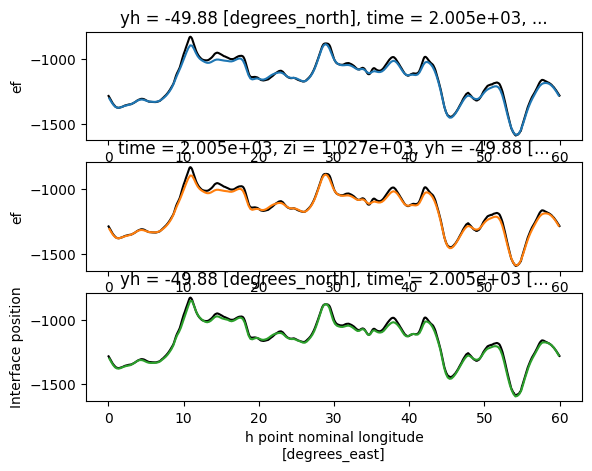

In [162]:
plt.subplot(3,1,1)
R32.e.sel(yh=-50,method='nearest').isel(zi=10)[0].plot(color='k')
R4_FGR3_gcmfilters.ef.sel(yh=-50,method='nearest').isel(zi=10)[0].plot(color='tab:blue')

plt.subplot(3,1,2)
R32.e.sel(yh=-50,method='nearest').isel(zi=10)[0].plot(color='k')
R4_FGR3_gmfilter.ef.sel(yh=-50,method='nearest').isel(zi=10)[0].plot(color='tab:orange')

plt.subplot(3,1,3)
R32.e.sel(yh=-50,method='nearest').isel(zi=10)[0].plot(color='k')
R4_coarsen.e.sel(yh=-50,method='nearest').isel(zi=10)[0].plot(color='tab:green')

plt.ylabel('Interface position')

In [179]:
def APE_interface(interface):
    '''
    Returns APE in units of kinetic energy per unit mass, i.e.
    m^3/s^2
    '''
    interface_rest = xr.DataArray([    0.,   -25.,   -75.,  -175.,  -300.,  -450.,  -625.,  -825.,
       -1050., -1300., -1600., -1950., -2350., -2850., -3400., -4000.], dims='zi')
    g = xr.DataArray([1.0e+01, 2.1e-03, 3.9e-03, 5.4e-03, 5.8e-03, 5.8e-03, 5.7e-03,
       5.3e-03, 4.8e-03, 4.2e-03, 3.7e-03, 3.1e-03, 2.4e-03, 1.7e-03,
       1.1e-03, 0.0e+00], dims='zi')
    
    coordinate_of_bottom = interface.isel(zi=-1).drop_vars(['zi'])
    
    hint = interface - interface_rest
    
    # Where bottom is upper than the rest interface
    hbot = np.maximum(coordinate_of_bottom - interface_rest,0)
    
    APE_instant = (0.5 * g * (hint**2))
    APE_constant = (0.5 * g * (hbot**2))
    
    return (APE_instant - APE_constant).drop_vars('zi')

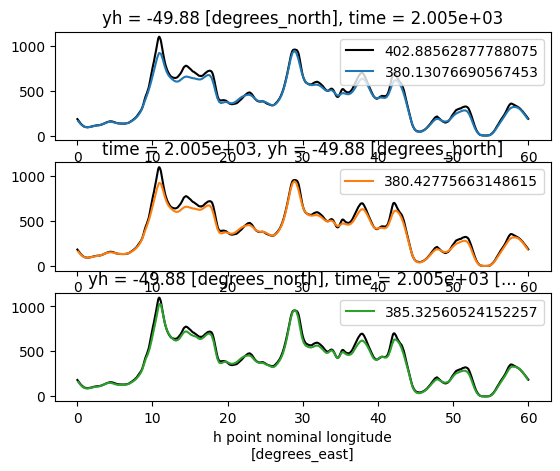

In [184]:
zi=10
plt.subplot(3,1,1)
ape = APE_interface(R32.e.sel(yh=-50,method='nearest')[0]).isel(zi=zi).compute()
ape.plot(color='k',label=float(ape.mean()))
ape = APE_interface(R4_FGR3_gcmfilters.ef.sel(yh=-50,method='nearest')[0]).isel(zi=zi).compute()
ape.plot(color='tab:blue', label=float(ape.mean()))
plt.legend()

plt.subplot(3,1,2)
APE_interface(R32.e.sel(yh=-50,method='nearest')[0]).isel(zi=zi).plot(color='k')
ape = APE_interface(R4_FGR3_gmfilter.ef.sel(yh=-50,method='nearest')[0]).isel(zi=zi).compute()
ape.plot(color='tab:orange', label=float(ape.mean()))
plt.legend()

plt.subplot(3,1,3)
APE_interface(R32.e.sel(yh=-50,method='nearest')[0]).isel(zi=zi).plot(color='k')
ape = APE_interface(R4_coarsen.e.sel(yh=-50,method='nearest')[0]).isel(zi=zi).compute()
ape.plot(color='tab:green', label=float(ape.mean()))
plt.legend()

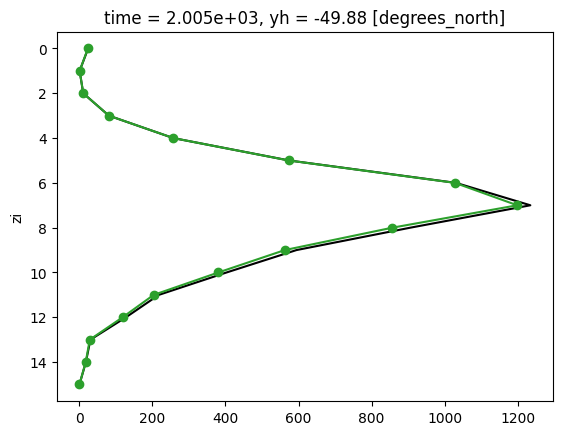

In [193]:
APE_interface(R32.e.isel(time=0)).sel(yh=-50,method='nearest').mean('xh').plot(color='k', y='zi')
APE_interface(R4_FGR3_gmfilter.ef.isel(time=0)).sel(yh=-50,method='nearest').mean('xh').plot(color='tab:green', y='zi',marker='o')
#APE_interface(R4_FGR3_gmfilter.ef.isel(time=0)).sel(yh=-50,method='nearest').mean('xh').plot(color='tab:orange',y='zi')
#APE_interface(R4_coarsen.e.isel(time=0)).sel(yh=-50,method='nearest').mean('xh').plot(color='tab:green',y='zi')

plt.gca().invert_yaxis()

In [194]:
APE_interface(R4_FGR3_gmfilter.ef.isel(time=0)).sel(yh=-50,method='nearest').mean('xh').sum().compute()

<xarray.DataArray ()> Size: 8B
array(5340.32891808)
Coordinates:
    time     float64 8B 2.005e+03
    yh       float64 8B -49.88

In [220]:
R4_FGR3_gmfilter.yh.sel(yh=-50,method='nearest')

<xarray.DataArray 'yh' ()> Size: 8B
array(-49.875)
Coordinates:
    yh       float64 8B -49.88
Attributes:
    long_name:       h point nominal latitude
    units:           degrees_north
    cartesian_axis:  Y

In [222]:
APE_interface(R32.e.isel(time=0)).mean('xh').sum('zi').sel(yh=slice(-50.5,-49.5)).compute()

<xarray.DataArray (yh: 32)> Size: 256B
array([5957.32530927, 5927.95774271, 5900.09187088, 5870.20093813,
       5839.25517335, 5808.43519671, 5778.37059532, 5748.3124426 ,
       5720.93870399, 5693.9177298 , 5669.1382728 , 5645.14910814,
       5620.18181175, 5594.73959023, 5569.33531109, 5541.45903156,
       5509.33319107, 5475.85625869, 5438.64555986, 5402.08888147,
       5361.12550129, 5322.48946269, 5284.36045365, 5246.7418142 ,
       5209.2301749 , 5169.00658111, 5130.78425122, 5094.87083526,
       5056.18929734, 5012.66804678, 4966.73879369, 4917.2160318 ])
Coordinates:
  * yh       (yh) float64 256B -50.48 -50.45 -50.42 ... -49.58 -49.55 -49.52
    time     float64 8B 2.005e+03

In [196]:
5340.32891808/5509.33319107

0.9693240058045616

In [197]:
0.9693240058045616 * 0.958

0.92861239756077

In [223]:
ape32 = APE_interface(R32.e.isel(time=0)).mean('xh').sum('zi').interp(yh=R4_FGR3_gmfilter.yh).compute()

In [202]:
apegm = APE_interface(R4_FGR3_gmfilter.ef.isel(time=0)).mean('xh').sum('zi').compute()

In [204]:
apegcm = APE_interface(R4_FGR3_gcmfilters.ef.isel(time=0)).mean('xh').sum('zi').compute()

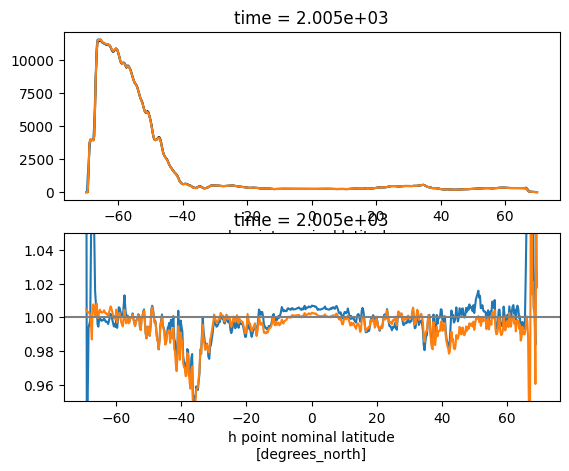

In [226]:
plt.subplot(2,1,1)
ape32.plot(color='k')
apegcm.plot(color='tab:blue')
apegm.plot(color='tab:orange')

plt.subplot(2,1,2)
(apegcm / ape32).plot(color='tab:blue')
(apegm / ape32).plot(color='tab:orange')

plt.ylim([0.95,1.05])
plt.axhline(y=1,color='tab:gray')